In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

In [ ]:
from google.colab import files
import os
import shutil

plt.rcParams["figure.figsize"] = (8,8)

# This is heavily based on the given solution for the class VAE exercise

In [ ]:
import os
import random
random.seed(1)

os.makedirs("results", exist_ok=True)

cuda2 = True # torch.cuda.is_available() check if a gpu is available
batch_size2 = 128
log_interval2 = 10
epochs2 = 2 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
train_loader_det = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
train_det = list(iter(train_loader_det))
test_loader_det = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
test_det = list(iter(test_loader_det))

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO

def train(model, optimizer, epoch):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
def test_expected_value_in_latent_space(encoder, dl=train_loader):
    with torch.no_grad():
        zs = []
        ys = []
        for i, (data, y) in enumerate(dl):
            data = data.to(device)
            _z, mu, _logvar = encoder(data)
            zs.append(mu)
            ys.append(y)
        zs = torch.cat(zs)
        ys = torch.cat(ys)
    zs = zs.cpu().detach().numpy()
    ys = ys.cpu().detach().numpy()
    return zs, ys

def plot_latent_space(encoder, dl=train_loader, filename="latent_space.png"):
    zs, ys = test_expected_value_in_latent_space(encoder, dl)
    z1, z2 = zs.T

    cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
             5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

    fig, ax = plt.subplots()
    for y in np.unique(ys):
        ix = np.where(ys == y)
        ax.scatter(z1[ix], z2[ix], c = cdict[y], label = int(y), s = 0.8)
    ax.legend(markerscale = 10)
    fig.savefig(filename, bbox_tight=True, transparent=True)
    plt.show()

In [ ]:
#Model evaluation on MNIST
def inspect_sample(datalist, i, model, cmap='viridis', bayesian=False, filename="sample.png"):
    #Choose first sample
    xs,ys = datalist[i]
    x = xs[0]
    model.eval()
    with torch.no_grad():
      if bayesian:
        x_recon, _,_,_,_ = model(x.to(device))
        x_recon = x_recon[0]
      else:
        x_recon, _,_ = model(x.to(device))
    fig, axs = plt.subplots(2,1, figsize=(16,10))
    axs[0].imshow(x[0], cmap=cmap)
    axs[1].imshow(x_recon.cpu().view(28,28), cmap=cmap)
    axs[0].set_title("Original", fontsize=28)
    axs[1].set_title("Reconstruction", fontsize=28)
    axs[0].axis("off")
    axs[1].axis("off")
    fig.savefig(filename, bbox_tight=True, transparent=True)
    plt.show()

def inspect_latentspace(dl, model, bayesian=False, filename="latent_space.png", conv=False):
    if conv:
      plot_latent_space(lambda x: model.encode(x), dl, filename)
    else:
      plot_latent_space(lambda x: model.encode(x.view(-1, 784)), dl, filename)

def mesh_plot(model, bayesian=False, cmap="viridis", filename="meshplot.png"):
    M = 12
    x = torch.linspace(start=0, end=1, steps=M+2)
    x = x[:-1]
    x = x[1:]

    mesh_x, mesh_y = torch.meshgrid(x, x)
    gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
    gauss_x = gauss.icdf(mesh_x)#.flip(0)
    gauss_y = gauss.icdf(mesh_y)

    fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
    for i in range(M):
        for j in range(M):
            x_val = gauss_x[i,j].item()
            y_val = gauss_y[i,j].item()
            if bayesian:
              im, _mu, _logvar = model.decode(torch.Tensor([y_val, x_val]).to(device))
              im_plt = im[0,:].reshape((28,28))
            else:
              im = model.decode(torch.Tensor([y_val, x_val]).to(device))
              im_plt = im.reshape((28,28))
            plot_me = im_plt.cpu().detach().numpy()
            ax[i,j].imshow(plot_me, cmap=cmap)
            ax[i,j].axis("off")

    slim=0.6
    plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
    plt.axis("off")
    plt.savefig(filename, bbox_tight=True, transparant=True)
    plt.show()

In [ ]:
# Returns batch of marginal likelihood estimates.
def importance_sampling(
    model,
    N, # number of samples to use for Monte Carlo estimator
    x, # batch of images
    conv=False,
):
    # Importance sampling for VAE. Oswin PML script, pp. 65.
    # and Kingma and Welling. "An Introduction to Variational Autoencoders".
    # Section 2.6.
    with torch.no_grad():
        # Draw from proposal distribution q(z|x) (decoder)
        qz_x, mu, logvar = model.encode(x)
        z = qz_x.rsample((N,))
        
        # Kingma and Welling, Section 1.7.3 for binary data:
        #TODO; ours is not really binary, but neither is loss func?

        # Note that the posterior has diagonal covariance
        # by definition of the decoder in the VAE class above.
        # Compute log q(z|x) = N(z;mu, diag(var))
        log_qz_x = qz_x.log_prob(z).sum(-1)
        #                          ^since diagonal variance => independent RVs
        #                           q(z|x) = prod_i q(z_i|x)
        #                           log q(z|x) = sum_i log q(z_i|x)
        #                           See Kingma Section 2.5.
        # Compute log p(z) = log N(z;0,I)
        log_pz = torch.distributions.normal.Normal(
            loc=torch.zeros_like(mu),
            scale=torch.ones_like(logvar),
        ).log_prob(z).sum(-1)
        # Compute log p(x|z) = sum_j log p(x_j|z) (by IID assumption)
        #                    = sum_j log Bernoulli(x_j; p_j)
        #                      with p = decoder(z)
        #                    = sum_j x_j log p_j + (1-x_j) * log(1-p_j)
        #                    = -1*BCE of x and decoder(z)
        recon = model.decode(z)
        #print(f"model.decode(z).shape={recon.shape}")
        if conv:
            B = x.shape[0]
            recon = recon.view(N, B, -1)
            x = x.view(B, -1)
        #print(f"model.decode(z).shape={recon.shape}")
        #print(f"x.shape={x.shape}")

        log_px_z = -1*F.binary_cross_entropy(
            recon,   # probabilities of Bernoulli R.V.s
            x.repeat((N,1,1)), # match decoder(z) shape
            reduction="none",
        ).sum(-1)
        # ^sum over x feature dimension
        #print(log_px_z.shape)
        #print(log_px_z)

        # p(x) ~= 1/N sum_i^N p(x|z^(i))p(z^(i)) / q(z^(i)|x)
        # log p(x) ~= log (1/N sum_i^N exp(log p(x|z^(i))+ log p(z^(i) - log q(z^(i)|x)))
        # log p(x) ~= log (sum_i^N exp(log p(x|z^(i))+ log p(z^(i) - log q(z^(i)|x))) - log(N)
        log_px = torch.logsumexp(log_px_z + log_pz - log_qz_x, 0) - np.log(N)
        
        #print("z", z.shape)
        #print("log_qz_x", log_qz_x.shape)
        #print("log_pz  ", log_pz.shape)
        #print("log_px_z", log_px_z.shape)
        #print("px", px.shape)
        return log_px


# Returns batch of marginal likelihood estimates.
def importance_sampling_bayesian(
    model,
    N, # number of samples to use for Monte Carlo estimator
    x, # batch of images
):
    # Importance sampling for VAE. Oswin PML script, pp. 65.
    # and Kingma and Welling. "An Introduction to Variational Autoencoders".
    # Section 2.6.
    with torch.no_grad():
        # Draw from proposal distribution q(z|x) (decoder)
        qz_x, mu, logvar = model.encode(x)
        z = qz_x.rsample((N,))
        
        # Kingma and Welling, Section 1.7.3 for binary data:
        #TODO; ours is not really binary, but neither is loss func?

        # Note that the posterior has diagonal covariance
        # by definition of the decoder in the VAE class above.
        # Compute log q(z|x) = N(z;mu, diag(var))
        log_qz_x = qz_x.log_prob(z).sum(-1)
        #                          ^since diagonal variance => independent RVs
        #                           q(z|x) = prod_i q(z_i|x)
        #                           log q(z|x) = sum_i log q(z_i|x)
        #                           See Kingma Section 2.5.
        # Compute log p(z) = log N(z;0,I)
        log_pz = torch.distributions.normal.Normal(
            loc=torch.zeros_like(mu),
            scale=torch.ones_like(logvar),
        ).log_prob(z).sum(-1)
        # Compute log p(x|z) = sum_j log p(x_j|z) (by IID assumption)
        #                    = sum_j log Bernoulli(x_j; p_j)
        #                      with p = decoder(z)
        #                    = sum_j x_j log p_j + (1-x_j) * log(1-p_j)
        #                    = -1*BCE of x and decoder(z)
        recon, _, _ = model.decode(z)
        L = recon.shape[0]
        B = x.shape[0]
        recon = recon.view(L, N, B, -1)
        log_px_z = -1*F.binary_cross_entropy(
            recon,   # probabilities of Bernoulli R.V.s
            x.repeat((L,N,1,1)), # match decoder(z) shape
            reduction="none",
        ).mean(0).sum(-1)
        # ^mean weigths ^sum over x feature dimension
        #print(log_px_z.shape)

        # p(x) ~= 1/N sum_i^N p(x|z^(i))p(z^(i)) / q(z^(i)|x)
        # log p(x) ~= log (1/N sum_i^N exp(log p(x|z^(i))+ log p(z^(i) - log q(z^(i)|x)))
        # log p(x) ~= log (sum_i^N exp(log p(x|z^(i))+ log p(z^(i) - log q(z^(i)|x))) - log(N)
        log_px = torch.logsumexp(log_px_z + log_pz - log_qz_x, 0) - np.log(N)
        
        #print("z", z.shape)
        #print("log_qz_x", log_qz_x.shape)
        #print("log_pz  ", log_pz.shape)
        #print("log_px_z", log_px_z.shape)
        #print("px", px.shape)
        return log_px


#importance_sampling(10, x0.view(-1, 784))[:3]

In [ ]:
def estimate_likelihood(model, num_samples, bayesian=False, dl=test_loader, conv=False):
  log_px_estimates = []
  for (x, _y) in dl:
      if conv:
        x = x.to(device)
        print(x.shape)
      else:
        x = x.view(-1, 784).to(device)
      if bayesian:
        log_px_estimates.append(importance_sampling_bayesian(model, num_samples, x))
      else:
        log_px_estimates.append(importance_sampling(model, num_samples, x, conv=conv))


  log_pX = torch.cat(log_px_estimates).mean()
  print('log p(x) ~= {:.4f}'.format(log_pX))
  print(torch.cat(log_px_estimates))

In [ ]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2
        self.fc3 = nn.Linear(2, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        mu, logvar = self.fc21(h2), self.fc22(h2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        gauss, mu, logvar = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        return self.decode(z), mu, logvar

In [ ]:
model = VAE().to(device)
print(summary(model, input_size=(128,1,28,28)))

optimizer = optim.Adam(model.parameters(), lr=1e-3)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [128, 784]                --
├─Linear: 1-1                            [128, 400]                314,000
├─Linear: 1-2                            [128, 100]                40,100
├─Linear: 1-3                            [128, 2]                  202
├─Linear: 1-4                            [128, 2]                  202
├─Linear: 1-5                            [128, 100]                300
├─Linear: 1-6                            [128, 400]                40,400
├─Linear: 1-7                            [128, 784]                314,384
Total params: 709,588
Trainable params: 709,588
Non-trainable params: 0
Total mult-adds (M): 90.83
Input size (MB): 0.40
Forward/backward pass size (MB): 1.83
Params size (MB): 2.84
Estimated Total Size (MB): 5.07


In [ ]:
epochs2=10
for epoch in range(1, epochs2 + 1):
    train(model, optimizer, epoch)
    test(model, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 188.0499
====> Test set loss: 166.9069
====> Epoch: 2 Average loss: 163.1134
====> Test set loss: 159.6472
====> Epoch: 3 Average loss: 158.0386
====> Test set loss: 156.4365
====> Epoch: 4 Average loss: 154.8252
====> Test set loss: 153.4703
====> Epoch: 5 Average loss: 152.1612
====> Test set loss: 151.0211
====> Epoch: 6 Average loss: 149.9008
====> Test set loss: 149.0077
====> Epoch: 7 Average loss: 148.2939
====> Test set loss: 147.8388
====> Epoch: 8 Average loss: 147.0720
====> Test set loss: 147.1282
====> Epoch: 9 Average loss: 146.1278
====> Test set loss: 146.5830
====> Epoch: 10 Average loss: 145.2163
====> Test set loss: 145.6156


### Find expected value in latent space for each number

In [ ]:
!ls

data  results  sample_data


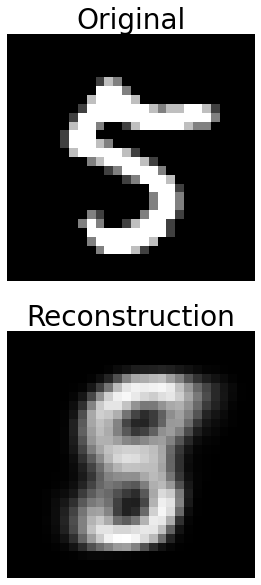

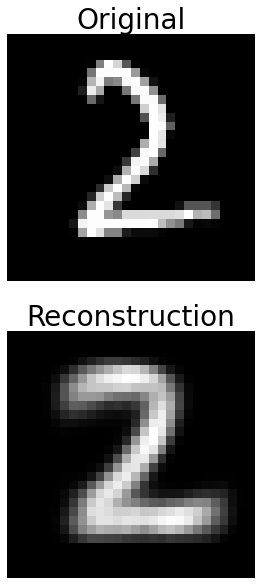

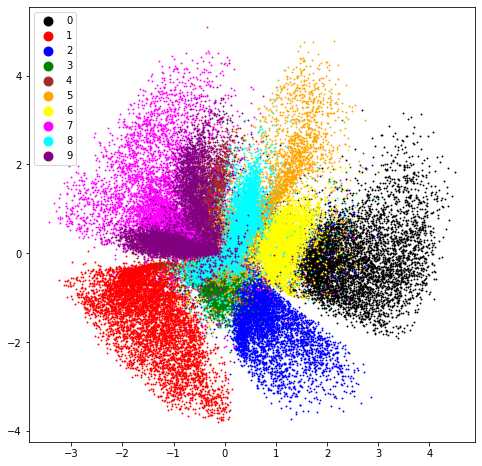

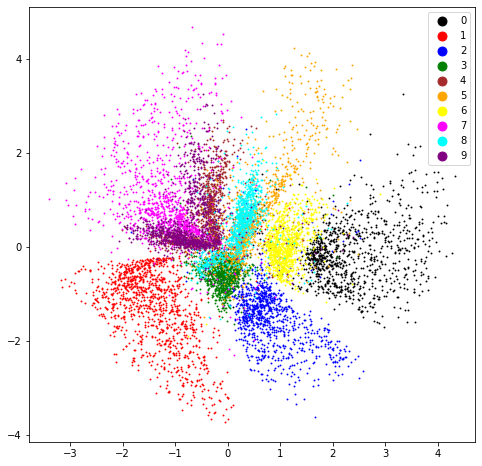

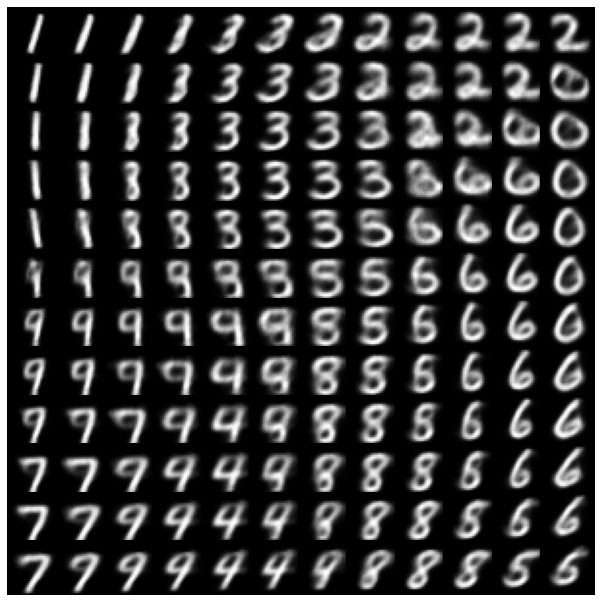

In [ ]:
model_name = "OriVAE"
savedir = f"{model_name}_eval"
os.makedirs(savedir, exist_ok=True)

inspect_sample(train_det, 4, model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_sample_train.png"))

inspect_sample(test_det, 4, model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_sample_test.png"))

inspect_latentspace(train_loader, model, filename=os.path.join(savedir, f"{model_name}_latent_train.png"))

inspect_latentspace(test_loader, model, filename=os.path.join(savedir, f"{model_name}_latent_test.png"))

mesh_plot(model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_meshgrid.png"))

In [ ]:
shutil.make_archive(f"{savedir}", 'zip', savedir)
files.download(f"{savedir}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
estimate_likelihood(model, 10)

log p(x) ~= -143.7252
tensor([-158.3340, -136.2575, -124.6599,  ...,  -98.8024, -205.4915,
        -126.9848])


# 2. Now let's visualize the output in a different way...

# Convolutional VAE

In [ ]:
# Define VAE model
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, stride=1)
        self.conv_mean   = nn.Conv2d(32, 64, 3, stride=2)
        self.conv_logvar = nn.Conv2d(32, 64, 3, stride=2)
        self.fc_mean   = nn.Linear(12*12*64, 2)
        self.fc_logvar = nn.Linear(12*12*64, 2)
        self.fc1 = nn.Linear(2, 12*12*64)
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, 3, stride=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x1 = F.relu(self.conv_mean(x)).view(-1, 12*12*64)
        x2 = F.relu(self.conv_logvar(x)).view(-1, 12*12*64)
        mu, logvar = self.fc_mean(x1), self.fc_logvar(x2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar

    def decode(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.conv2(z.view(-1, 64, 12, 12)))
        return torch.sigmoid(self.conv3(z))

    def forward(self, x):
        gauss, mu, logvar = self.encode(x)
        z = gauss.rsample()
        return self.decode(z).view(-1, 784), mu, logvar

In [ ]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 2 # latent dimension for sampling

In [ ]:
class ConvVAE2(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=2):
        super(ConvVAE2, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encode(self, x):
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return self.reparameterize(mu, logVar), mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x.view(-1,784)

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decode
        # output, mu, and logVar are returned for loss computation
        z, mu, logVar = self.encode(x)
        out = self.decode(z)
        return out, mu, logVar

In [ ]:
os.makedirs("results/conv", exist_ok=True)

conv_model = ConvVAE().to(device)
print(summary(conv_model, input_size=(128,1,28,28)))

optimizer = optim.Adam(conv_model.parameters(), lr=1e-3)


Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE                                  [128, 784]                --
├─Conv2d: 1-1                            [128, 32, 26, 26]         320
├─Conv2d: 1-2                            [128, 64, 12, 12]         18,496
├─Conv2d: 1-3                            [128, 64, 12, 12]         18,496
├─Linear: 1-4                            [128, 2]                  18,434
├─Linear: 1-5                            [128, 2]                  18,434
├─Linear: 1-6                            [128, 9216]               27,648
├─ConvTranspose2d: 1-7                   [128, 32, 26, 26]         18,464
├─ConvTranspose2d: 1-8                   [128, 1, 28, 28]          289
Total params: 120,581
Trainable params: 120,581
Non-trainable params: 0
Total mult-adds (G): 2.34
Input size (MB): 0.40
Forward/backward pass size (MB): 73.42
Params size (MB): 0.48
Estimated Total Size (MB): 74.30


In [ ]:
conv_model2 = ConvVAE2().to(device)
print(summary(conv_model2, input_size=(128,1,28,28)))

optimizer2 = optim.Adam(conv_model2.parameters(), lr=1e-3)

Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE2                                 [128, 784]                --
├─Conv2d: 1-1                            [128, 16, 24, 24]         416
├─Conv2d: 1-2                            [128, 32, 20, 20]         12,832
├─Linear: 1-3                            [128, 2]                  25,602
├─Linear: 1-4                            [128, 2]                  25,602
├─Linear: 1-5                            [128, 12800]              38,400
├─ConvTranspose2d: 1-6                   [128, 16, 24, 24]         12,816
├─ConvTranspose2d: 1-7                   [128, 1, 28, 28]          401
Total params: 116,069
Trainable params: 116,069
Non-trainable params: 0
Total mult-adds (G): 1.68
Input size (MB): 0.40
Forward/backward pass size (MB): 45.90
Params size (MB): 0.46
Estimated Total Size (MB): 46.76


In [ ]:
epochs2 = 10
for epoch in range(1, epochs2 + 1):
    train(conv_model, optimizer, epoch)
    test(conv_model, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device)
        sample = conv_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/conv/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 236.3788
====> Test set loss: 183.8357
====> Epoch: 2 Average loss: 175.2363
====> Test set loss: 169.7416
====> Epoch: 3 Average loss: 167.5316
====> Test set loss: 165.6619
====> Epoch: 4 Average loss: 163.8491
====> Test set loss: 162.6004
====> Epoch: 5 Average loss: 161.3725
====> Test set loss: 160.9792
====> Epoch: 6 Average loss: 159.8877
====> Test set loss: 160.0141
====> Epoch: 7 Average loss: 158.6679
====> Test set loss: 159.0497
====> Epoch: 8 Average loss: 157.8124
====> Test set loss: 157.8667
====> Epoch: 9 Average loss: 157.0117
====> Test set loss: 157.1411
====> Epoch: 10 Average loss: 156.5839
====> Test set loss: 156.6519


In [ ]:
epochs2 = 5
for epoch in range(1, epochs2 + 1):
    train(conv_model2, optimizer2, epoch)
    test(conv_model2, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device)
        sample = conv_model2.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/conv/sample_' + str(epoch) + '.png'
                  )

NameError: ignored

# Evaluate conv

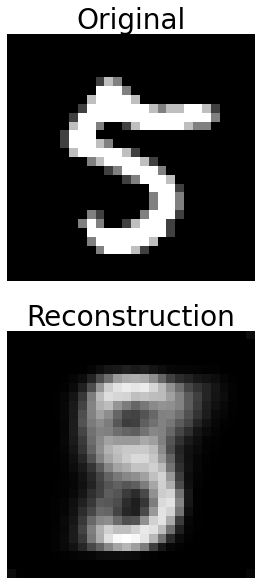

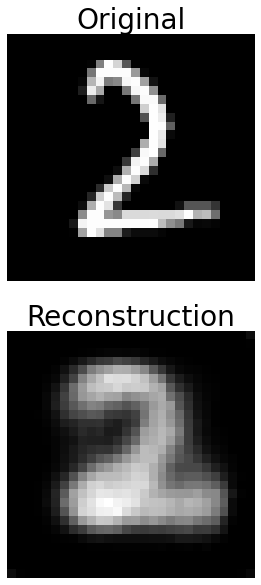

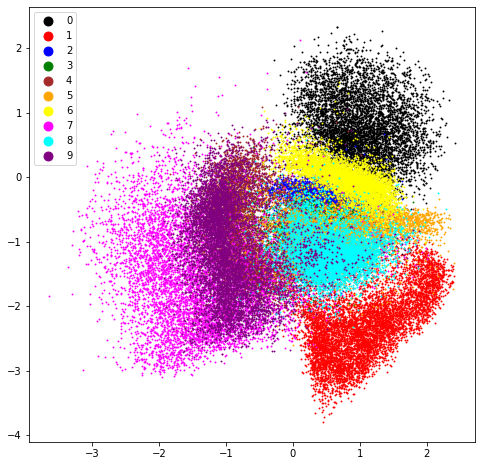

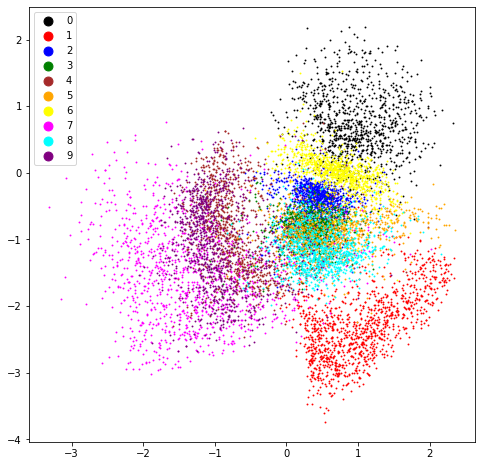

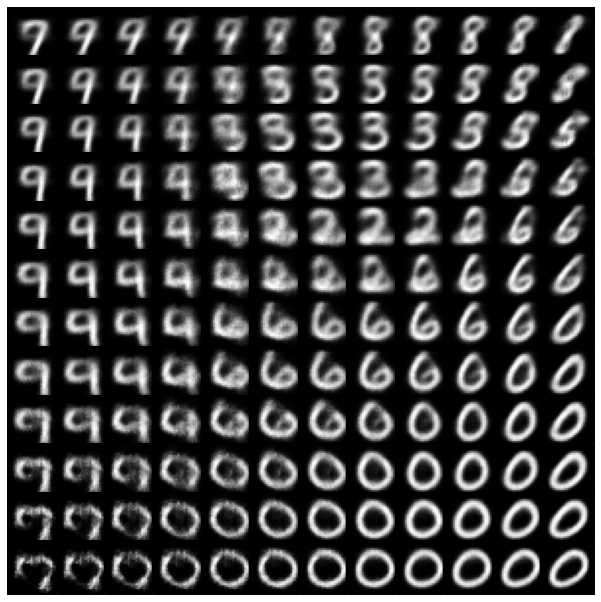

In [ ]:
model = conv_model
model_name = "ConvVAE"
savedir = f"{model_name}_eval"
os.makedirs(savedir, exist_ok=True)

inspect_sample(train_det, 4, model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_sample_train.png"))

inspect_sample(test_det, 4, model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_sample_test.png"))

inspect_latentspace(train_loader, model, filename=os.path.join(savedir, f"{model_name}_latent_train.png"), conv=True)

inspect_latentspace(test_loader, model, filename=os.path.join(savedir, f"{model_name}_latent_test.png"), conv=True)

mesh_plot(model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_meshgrid.png"))

In [ ]:
shutil.make_archive(f"{savedir}", 'zip', savedir)
files.download(f"{savedir}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
estimate_likelihood(conv_model, 10, conv=True)

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([12

# Bayesian VAE

In [ ]:
device = "cpu"

In [ ]:
from torch.nn import Parameter
import math

In [ ]:
train_data = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor())
N_train=60000
N_train = train_data.data.shape[0]
N_train

60000

In [ ]:
# Define Bayesian VAE model
class BVAE222(nn.Module):
    def __init__(self):
        super(BVAE222, self).__init__()

        #phi(for z)
        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2

        #phi(for theta)
        self.weight_mu_theta1 = Parameter(torch.zeros(784, 2)).to(device)
        self.weight_logvar_theta1 = Parameter(torch.zeros(784, 2)).to(device)
        self.bias_mu_theta1 = Parameter(torch.zeros(784)).to(device)
        self.bias_logvar_theta1 = Parameter(torch.zeros(784)).to(device)


        #theta
        #self.fc3 = nn.Linear(2, 100) # 20 -> 2
        #self.fc3a = nn.Linear(100, 400)
        #self.fc4 = nn.Linear(400, 784)
        self.init_parameters()
        
        # Number of Monte Carlo samples for estimating ELBO
        self.L = 10

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        mu, logvar = self.fc21(h2), self.fc22(h2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar
    
    def init_parameters(self):
        stdv1 = 1. / math.sqrt(self.weight_mu_theta1.size(1))
        self.weight_mu_theta1.data.uniform_(-stdv1, stdv1)
        self.weight_logvar_theta1.data.uniform_(-stdv1, stdv1)
        self.bias_mu_theta1.data.uniform_(-stdv1, stdv1)
        self.bias_logvar_theta1.data.uniform_(-stdv1, stdv1)
    
    def sample_theta(self, w_mu, w_logvar, b_mu, b_logvar):
        weight = w_mu + torch.exp(0.5*w_logvar) * torch.randn((self.L, *w_logvar.shape)).to(device)
        bias   = b_mu + torch.exp(0.5*b_logvar) * torch.randn((self.L, *b_logvar.shape)).to(device)
        return weight, bias

    def decode(self, z):
        #weight = torch.distributions.normal.Normal(self.weight_mu_theta, torch.exp(0.5*self.weight_logvar_theta)).rsample()
        #bias = torch.distributions.normal.Normal(self.bias_mu_theta, torch.exp(0.5*self.bias_logvar_theta)).rsample()
        #Draw theta
        weight1, bias1 = self.sample_theta(
            self.weight_mu_theta1, self.weight_logvar_theta1,
            self.bias_mu_theta1, self.bias_logvar_theta1
        ) # [784,2]   [10,784,2]   z: [128, 2]
        #print("w,b", weight1.shape, bias1.shape)
        #print("w.T,b.T", weight1.T.shape, bias1.T.shape)
        #h3 = torch.matmul(z, weight1.view(-1,2).T) + bias1.view(-1)
        #print("h3", h3.shape)
        #h3 = h3.view(z.shape[0], self.L, 784)
        #h3 = F.relu(h3)
        
        z = z.view(-1,2,1)
        w = weight1.unsqueeze(1).expand(self.L, z.shape[0], 784, 2)
        b = bias1.view(self.L, -1, 1).unsqueeze(1).expand(self.L, z.shape[0], 784, 1)

        h3 = F.relu(torch.matmul(w, z)) + b
        #print(h3.shape)
        h3 = h3.squeeze(-1)
        #print(h3.shape)

        mu_theta = torch.cat([self.weight_mu_theta1.view(1,-1), self.bias_mu_theta1.view(1,-1)], dim=1)
        logvar_theta = torch.cat([self.weight_logvar_theta1.view(1,-1), self.bias_logvar_theta1.view(1,-1)], dim=1)

        #print(h3.shape, mu_theta.shape, logvar_theta.shape)
        return torch.sigmoid(h3), mu_theta, logvar_theta

    def forward(self, x):
        gauss, mu, logvar = self.encode(x.view(-1, 784))
        z = gauss.rsample()#(self.L,))
        #print(z.shape)
        x_hat, mu_theta, logvar_theta = self.decode(z)
        return x_hat, mu, logvar, mu_theta, logvar_theta

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_bayesian(recon_x, x, mu, logvar, mu_theta, logvar_theta, include_t = True):
    batch_size = x.shape[0]
    N = N_train/batch_size
    x = x.view(-1, 784).unsqueeze(0).repeat(Bmodel.L,1,1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='none')
    # ^ [L, batch, 784]
    BCE = BCE.mean(0) # Expectation wrt weight distribution
    # ^ [batch, 784]
    BCE = BCE.sum()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD_theta = 0 if not include_t else -0.5 * torch.sum(1 + logvar_theta - mu_theta.pow(2) - logvar_theta.exp())
    #print(BCE.item(), KLD.item(), KLD_theta.item(), N*(BCE+KLD).item())
    return N*(BCE + KLD) + KLD_theta # -ELBO

def train_bayesian(model, optimizer, epoch, include_t=True):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar, mu_theta, logvar_theta = model(data)
        loss = loss_function_bayesian(recon_batch, data, mu, logvar, mu_theta, logvar_theta, include_t=include_t)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test_bayesian(model, epoch, include_t=True):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, mu_theta, logvar_theta = model(data)
            test_loss += loss_function_bayesian(recon_batch, data, mu, logvar, mu_theta, logvar_theta, include_t=include_t).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
Bmodel = BVAE222().to(device)
optimizer = optim.Adam(Bmodel.parameters(), lr=1e-2)

In [ ]:
epochs2 = 20
for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel, optimizer, epoch)
    test_bayesian(Bmodel, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel.decode(sample)
        sample = sample.mean(0).cpu() # discard all but first
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 162205.0213
====> Test set loss: 111126.2553
====> Epoch: 2 Average loss: 101600.3623
====> Test set loss: 97557.5784
====> Epoch: 3 Average loss: 92844.9589
====> Test set loss: 90448.4517
====> Epoch: 4 Average loss: 88620.8141
====> Test set loss: 88085.9776
====> Epoch: 5 Average loss: 87024.7763
====> Test set loss: 87141.6701
====> Epoch: 6 Average loss: 86171.0732
====> Test set loss: 86493.6376
====> Epoch: 7 Average loss: 85661.9875
====> Test set loss: 86294.8166
====> Epoch: 8 Average loss: 85375.0506
====> Test set loss: 85908.3081
====> Epoch: 9 Average loss: 85153.4984
====> Test set loss: 85750.6378
====> Epoch: 10 Average loss: 85005.9709
====> Test set loss: 85684.6082
====> Epoch: 11 Average loss: 84904.8063
====> Test set loss: 85652.2596
====> Epoch: 12 Average loss: 84819.6057
====> Test set loss: 85659.3086
====> Epoch: 13 Average loss: 84802.2499
====> Test set loss: 85473.5827
====> Epoch: 14 Average loss: 84738.8567
====> Test set l

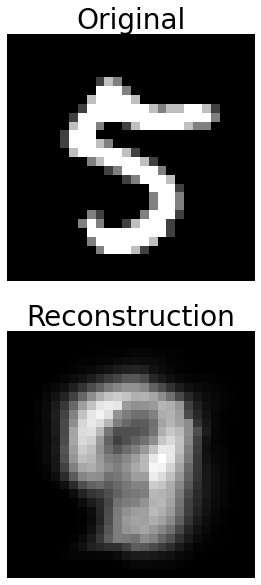

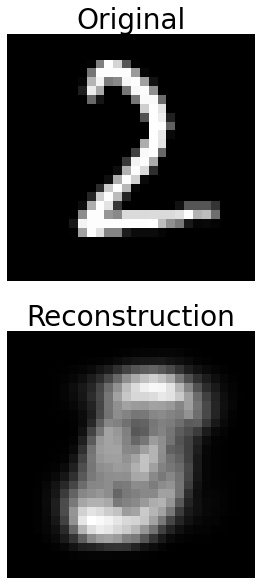

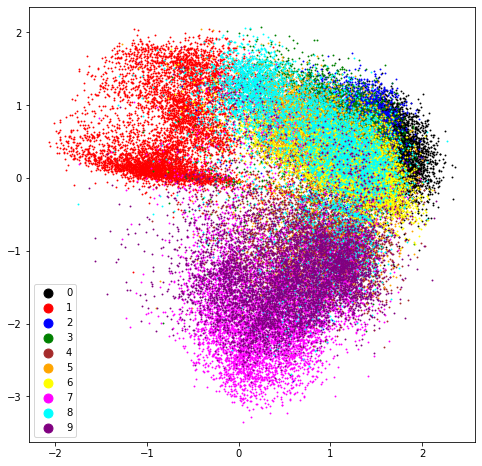

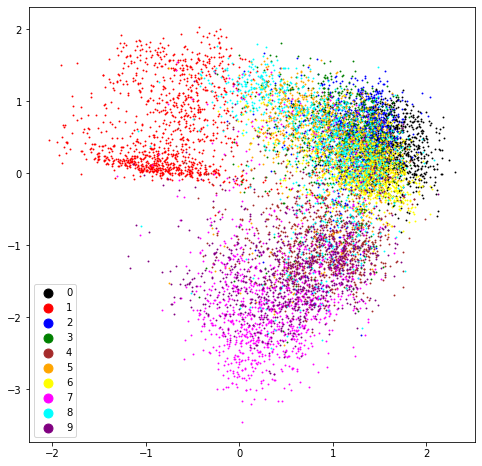

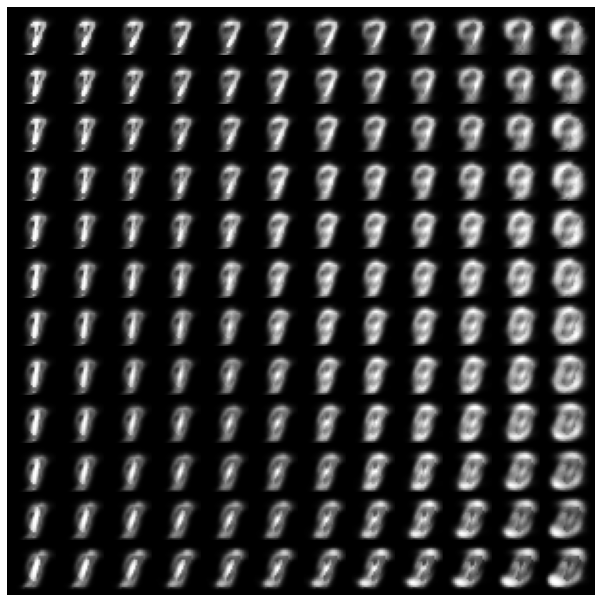

In [ ]:
model = Bmodel
model_name = "BayVAE"
savedir = f"{model_name}_eval"
os.makedirs(savedir, exist_ok=True)

inspect_sample(train_det, 4, model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_sample_train.png"), bayesian=True)

inspect_sample(test_det, 4, model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_sample_test.png"), bayesian=True)

inspect_latentspace(train_loader, model, filename=os.path.join(savedir, f"{model_name}_latent_train.png"), bayesian=True)

inspect_latentspace(test_loader, model, filename=os.path.join(savedir, f"{model_name}_latent_test.png"), bayesian=True)

mesh_plot(model, cmap="gray", filename=os.path.join(savedir, f"{model_name}_meshgrid.png"), bayesian=True)

In [ ]:
shutil.make_archive(f"{savedir}", 'zip', savedir)
files.download(f"{savedir}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
estimate_likelihood(model, 10, bayesian=True)

log p(x) ~= -179.4431
tensor([-166.4680, -161.3094,  -91.0207,  ..., -160.5600, -169.8105,
        -170.8082])


# PPCA

In [ ]:
#See notebook A_ppca.ipynb